# Surface Defect Detection

## 1. Introduction

In this notebook, we are going to create a convolutional neural network (CNN) that can detect surface defects.
Previously we have used Torch but now PyTorch will be used.

PyTorch is the freshest flavour of the Torch. It combines customization of Torch with Python ease of use. It completely covers the Torch functionality, on top of that, new Autograd mechanism, dataset loaders and lots of utilities have been added for convenience.

## 2. Code

First, let's import required packages...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Spectral7
from bokeh.io import output_notebook
from graphviz import Digraph
import numpy as np
import time
import copy
import os
import PIL
%matplotlib inline
plt.ion()
output_notebook()

Loading BokehJS ...

## 2.1 Dataset transformations
PyTorch lets us define a set of transformations to the loaded datasets. 

First images are converted to Torch tensors and then we will be scaling the images to 64 pixels in the smaller dimension. 

In [2]:
baseDirectory = 'g:/Selim/Thesis/Code/PyTorch/'
setDirectory = '3MAll'
setImageSize = 64

# 3MAll set mean and std values
# mean : 0.498283411655
# std : 0.0879390792679
setMean = [0.498, 0.498, 0.498]
setStd = [0.087, 0.087, 0.087]

In [3]:
dataTransforms = {
    'train': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.CenterCrop(setImageSize),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
    'test': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.CenterCrop(setImageSize),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
}

## 2.2 Loading datasets
Unlike Torch, PyTorch now supports direct image folder loading as the data. This completely removes the big dataset preparation step.

Additionally new dataset loaders allow setting batch size, shuffle and several other useful parameters.

Lastly checking the CUDA support is now easier with `torch.cuda.is_available()`

In [4]:
setPath = os.path.join(baseDirectory, setDirectory)
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(setPath, x), dataTransforms[x])
           for x in ['train', 'test']}

datasetLoaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4, shuffle=True, num_workers=4)
                for x in ['train', 'test']}

testLoader = torch.utils.data.DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=4)

datasetSizes = {x: len(datasets[x]) for x in ['train', 'test']}
datasetClasses = datasets['train'].classes

useGPU = torch.cuda.is_available()

print(str(datasetSizes) + ' images will be used.' )
print('GPU will ' + ('' if useGPU else 'not ') + 'be used.' )

{'train': 8950, 'test': 632} images will be used.
GPU will be used.


## 2.3 Auxiliary functions

### 2.3.1 ImShow
Here we define the simple image displaying function and use the new dataset iterator to get one random batch to display it.

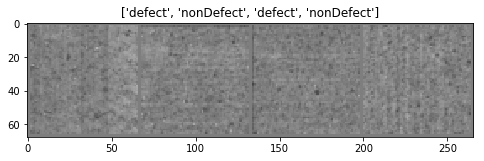

In [5]:
def ImShow(input, title=None):
    input = input.numpy().transpose((1, 2, 0))
    input = setStd * input + setMean
    plt.figure(figsize=(8,8))
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(datasetLoaders['train']))
out = torchvision.utils.make_grid(inputs)
ImShow(out, title=[datasetClasses[x] for x in classes])

### 2.3.2 VisualizeModel

This function helps displaying the predictions of the network.

In [6]:
def VisualizeModel(model, numImages=6):
    imagesSoFar = 0
    fig = plt.figure()
    
    for i, data in enumerate(datasetLoaders['test']):
        inputs, labels = data
        if useGPU:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            imagesSoFar += 1
            ax = plt.subplot(numImages // 2, 2, imagesSoFar)
            ax.axis('off')
            ax.set_title('Predicted: {}'.format(datasetClasses[labels.data[j]]))
            ImShow(inputs.cpu().data[j])
            
            if imagesSoFar == numImages:
                return

## 2.4 Training functions

This section contains functions used in training the network. First we should create the arrays to keep the error and learning rate changes.

In [7]:
trainLRValues = []
trainAccuracyTrain = []
trainAccuracyTest = []
trainErrorTrain = []
trainErrorTest = []

grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

### 2.4.1 TrainModelMiniBatch

Here we have 2 different training functions. First one uses mini batches and a separate learning-rate scheduler function for training.

In [37]:
def TrainModelMiniBatch(model, criterion, optimizer, lr_scheduler, trainAccuracyArray, testAccuracyArray, 
                        lrLogArray, trainErrorArray, testErrorArray, num_epochs=25):
    since = time.time()
    del trainAccuracyArray[:]
    del testAccuracyArray[:]
    del lrLogArray[:]
    del trainErrorArray[:]
    del testErrorArray[:]
    
    best_model = model
    best_acc = 0.0
    currentLr = 0        

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                optimizer, currentLr = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(datasetLoaders[phase]):
                # wrap them in Variable
                if useGPU:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
                if i % 250 == 0:
                    print('epoch {} batch {}/{} loss {:.3f}'.format(
                                epoch, i, len(datasetLoaders[phase]), loss.data[0]))

            epoch_loss = running_loss / datasetSizes[phase]
            epoch_acc = running_corrects / datasetSizes[phase]
            
            if phase == 'train':
                trainErrorArray.append(epoch_loss)
                trainAccuracyArray.append(epoch_acc)
                lrLogArray.append(currentLr)

            if phase == 'test':
                testErrorArray.append(epoch_loss)
                testAccuracyArray.append(epoch_acc)
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

### 2.4.2 TrainModelBatch

This is the previous method of training which uses all of the images in the training set for each training iteration.

In [9]:
def TrainModelBatch(model, criterion, optimizer, lrDecay, trainAccuracyArray, 
                    lrLogArray, trainErrorArray, maxIteration):
    currentIteration = 0
    del trainAccuracyArray[:]
    del lrLogArray[:]
    del trainErrorArray[:]
    # TODO: Log the learning rate somehow!
    #currentLr = 0 
    
    startTime = time.time()
    trainSetSize = datasetSizes['train']
    
    shuffledIndices = torch.randperm(trainSetSize)
    print('Started training...')
    
    while True:
        runningLoss = 0.0
        runningCorrects = 0
        for iInput, data in enumerate(datasetLoaders['train'], 0):
            inputs, labels = data
            if useGPU:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #print(iInput)
            runningLoss += loss.data[0]
            runningCorrects += torch.sum(preds == labels.data)
            
        currentError = runningLoss / trainSetSize
        currentAccuracy = runningCorrects / trainSetSize
        
        trainErrorArray.append(currentError)
        trainAccuracyArray.append(currentAccuracy)
        print('Iteration: ' + str(currentIteration) + '# current error = ' + str(currentError))
        currentIteration += 1
        
        if maxIteration > 0 and currentIteration > maxIteration:
            print('# Maximum iteration reached. End of training.')
            print('# Training error = ' + str(currentError))
            timeElapsed = time.time() - startTime            
            print('Training complete in {:.0f}m {:.0f}s'.format(timeElapsed // 60, timeElapsed % 60))
            break


### 2.4.3 ExpLRScheduler

Updates the learning-rate after each `lr_decay_epoch` number of epochs.

In [10]:
def ExpLRScheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    return optimizer, lr

## 2.5 Definition of neural network

### 2.5.1 Network module
Similar to Torch, here we define the neural network using separate modules.
First module handles the convolutional part of the network. After that a reshape operation adjust the convolution result for the following fully-connected layer module. Lastly, the result is applied to the fully-connected layer of the network and decisions are obtained with LogSoftMax operation in the end.

In [13]:
# Currently, weights are not shared.
# TODO: Try weight sharing with looping the element
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.reluIn = nn.ReLU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.reluI2 = nn.ReLU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        self.convI3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.reluI3 = nn.ReLU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 5)) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.reluIn(convInResult))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.reluI2(convI2Result))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.reluI3(convI3Result))
        
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

net = Net()
if useGPU:
    net = net.cuda()

### 2.5.2 Criterion and optimizer
We successfully created our neural network. Now it is time to define a loss function and the optimizer.

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

if useGPU:
    criterion = criterion.cuda()

## 2.6 Training

Mini-batch training method is preferred with PyTorch. It converges faster than the batch training method.

*Example*

*Mini-batch : With GTX 1070, 10 epochs train in 7m26s with 97.6% train and 97.6% test accuracy.*

*Batch      : With GTX 1070, 10 epochs train in 7m48s with 98.4% train and 96.5% test accuracy.*

### 2.6.1 Training with mini-batch method
Mini-batch method first selects n items randomly from the dataset and runs one epoch on the selected subset. Weights are updated only by looking to the selected subset.

In [38]:
TrainModelMiniBatch(net, criterion, optimizer, ExpLRScheduler, trainAccuracyTrain, trainAccuracyTest, trainLRValues, 
                    trainErrorTrain, trainErrorTest, num_epochs=1)   

Epoch 0/0
----------
LR is set to 0.001
epoch 0 batch 0/2238 loss 0.002
epoch 0 batch 250/2238 loss 0.027
epoch 0 batch 500/2238 loss 0.027
epoch 0 batch 750/2238 loss 0.022
epoch 0 batch 1000/2238 loss 0.015
epoch 0 batch 1250/2238 loss 0.021
epoch 0 batch 1500/2238 loss 0.050
epoch 0 batch 1750/2238 loss 0.058
epoch 0 batch 2000/2238 loss 0.208
train Loss: 0.0119 Acc: 0.9865
epoch 0 batch 0/158 loss 0.001
test Loss: 0.0544 Acc: 0.9399

Training complete in 0m 53s
Best val Acc: 0.939873


Net (
  (convIn): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (reluIn): ReLU ()
  (poolIn): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (convI2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (reluI2): ReLU ()
  (poolI2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (convI3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (reluI3): ReLU ()
  (poolI3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc): Sequential (
    (0): Linear (2048 -> 4096)
    (1): ReLU ()
    (2): Dropout (p = 0.5)
    (3): Linear (4096 -> 4096)
    (4): ReLU ()
    (5): Dropout (p = 0.5)
    (6): Linear (4096 -> 4096)
    (7): ReLU ()
    (8): Dropout (p = 0.5)
    (9): Linear (4096 -> 5)
  )
  (logsmax): LogSoftmax ()
)

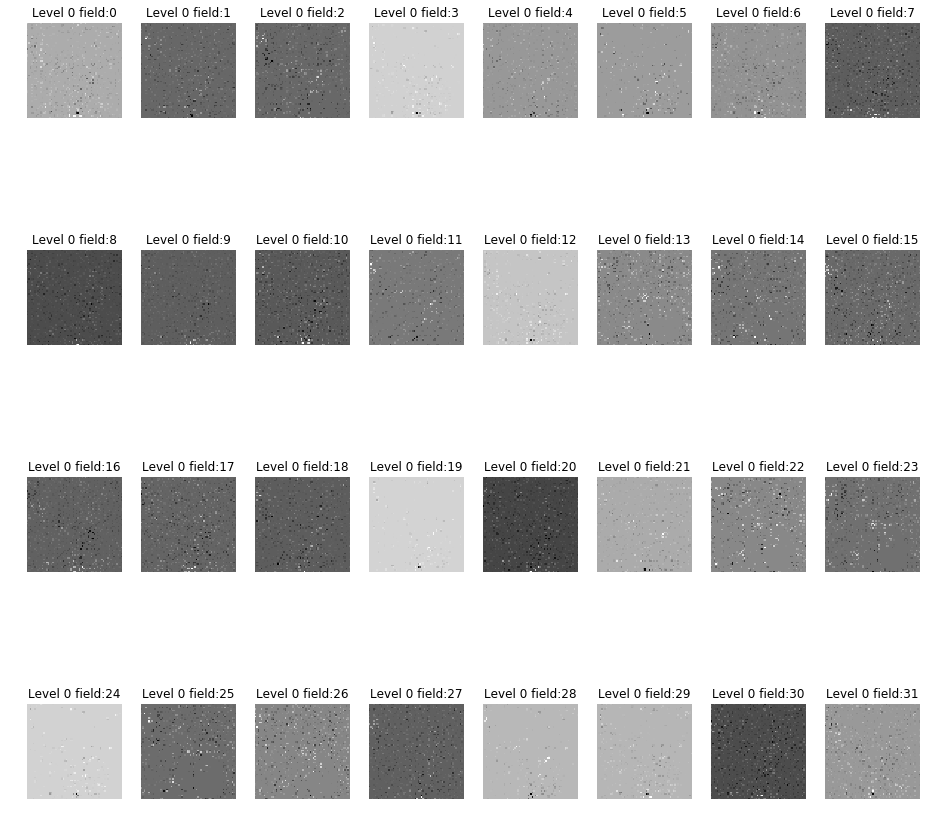

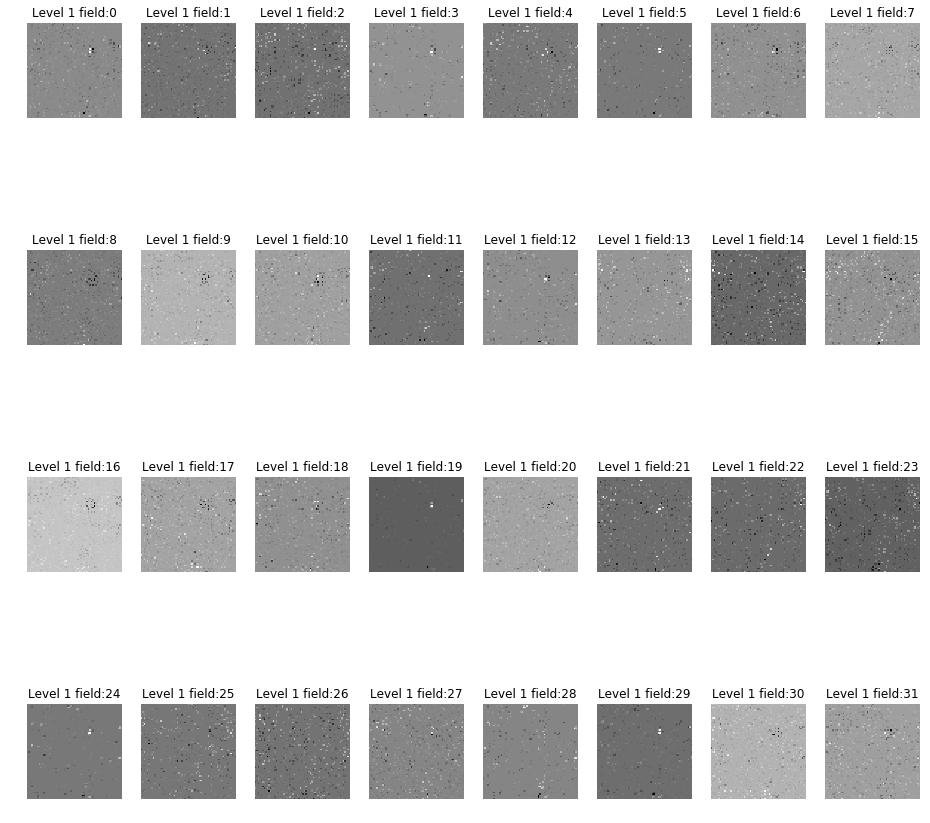

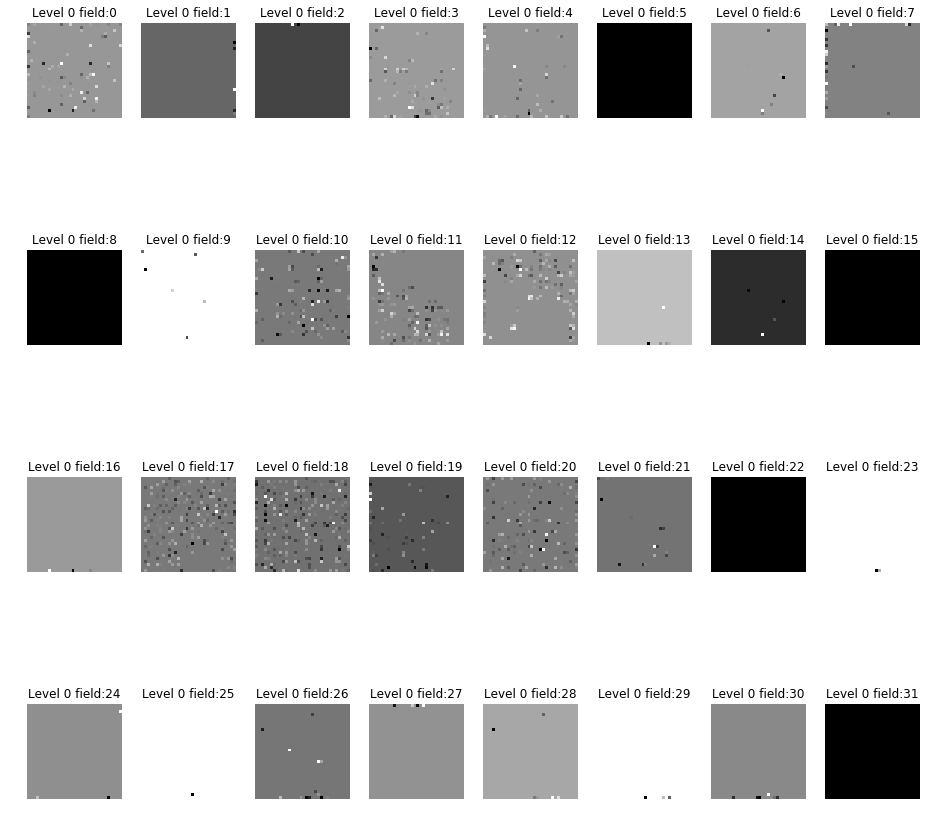

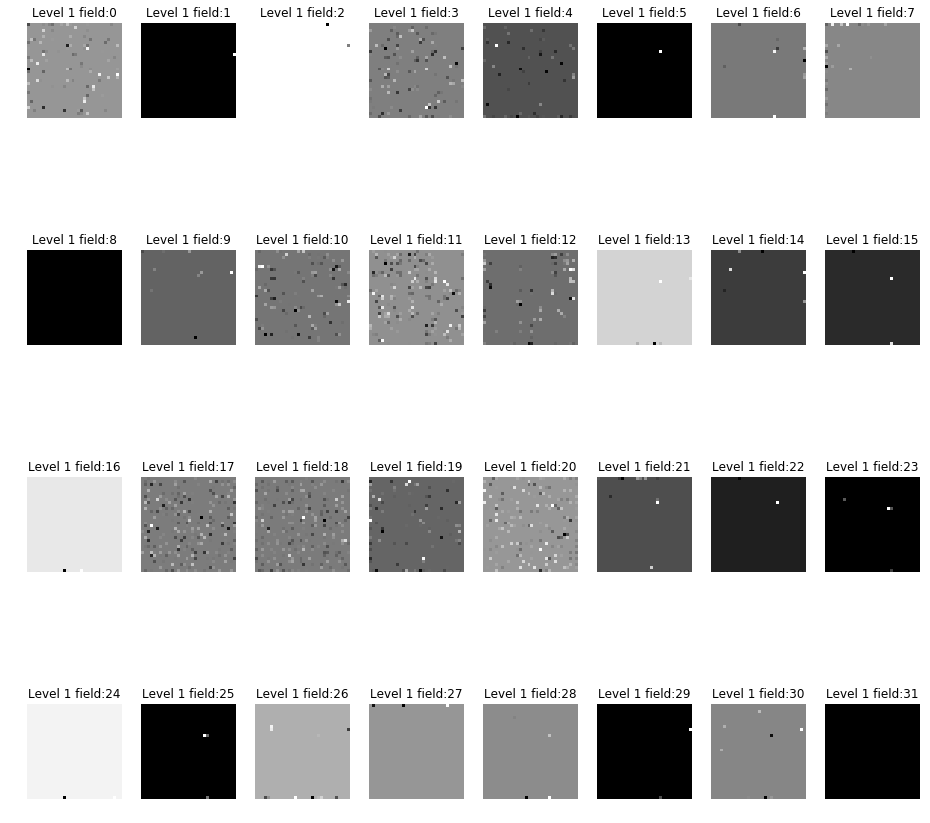

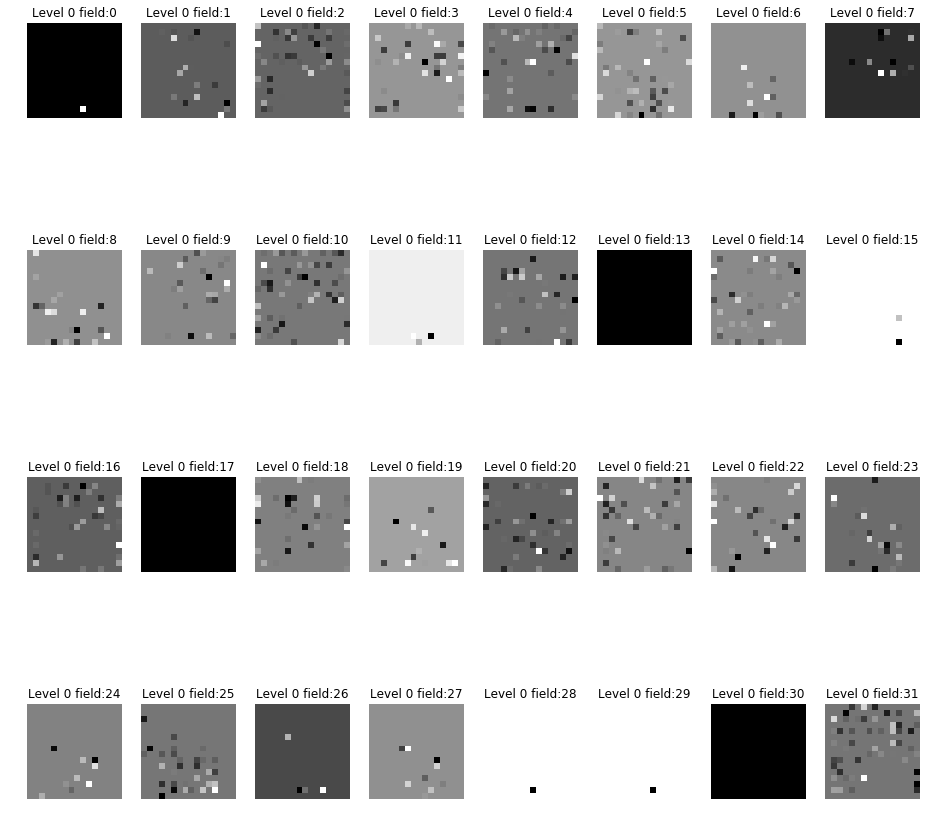

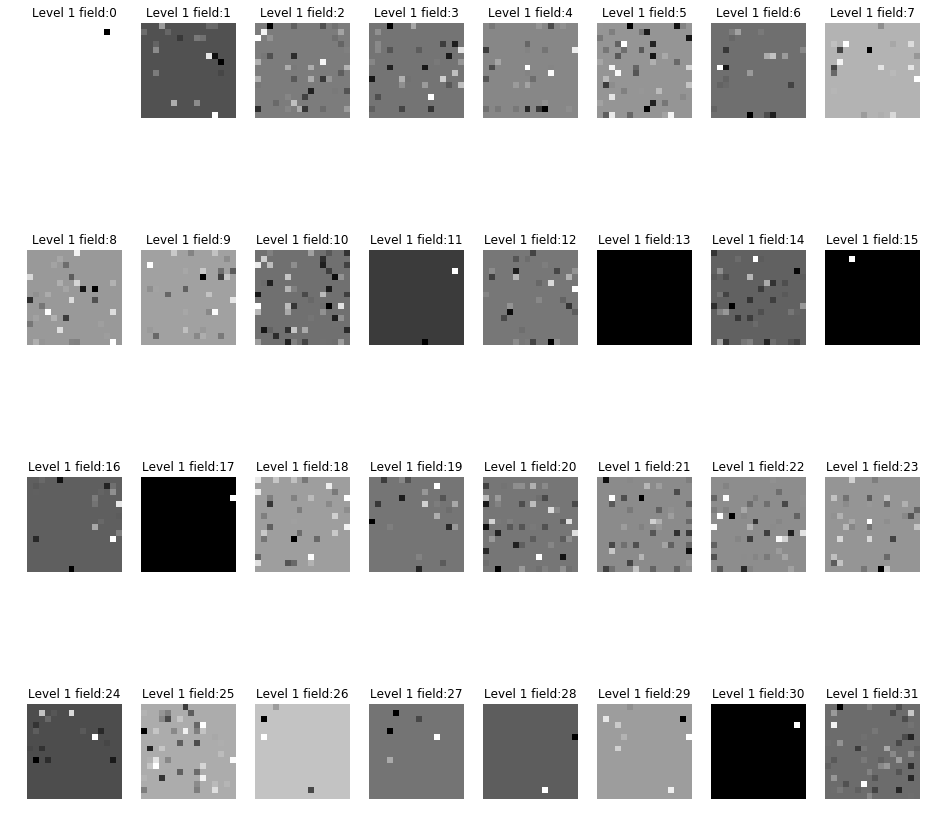

In [24]:
gradIn = grads['convInGrad']
gradI2 = grads['convI2Grad']
gradI3 = grads['convI3Grad']

def PlotActivationMaps(gradients):
    for iT in range(gradients.size()[0]):
        plt.figure(figsize=(16, 16))
        for z in range(gradients.size()[1]):
            plt.subplot(4, 8, z+1)
            plt.title('Level ' + str(iT) + ' field:' + str(z))
            plt.axis('off')
            
            plt.imshow(gradients[iT, z, :, :].data.cpu().numpy(), interpolation='nearest', cmap='gray')
PlotActivationMaps(gradIn)
PlotActivationMaps(gradI2)
PlotActivationMaps(gradI3)

### 2.6.2 Training with batch method
Batch method uses all of the images in the dataset to determine the gradient for each epoch.

In [67]:
#TrainModelBatch(net, criterion, optimizer, 0, trainAccuracyTrain, trainLRValues, trainErrorTrain, maxIteration=5)

In [15]:
def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

inputs = torch.randn(1,3,64,64)
y = net(Variable(inputs.cuda()))
make_dot(y)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

### 2.6.3 Visualization of the progress


In [26]:
def PlotArrays(arrays, labels, xlabel, ylabel, title):
    p = figure(title=title, x_axis_label=xlabel, y_axis_label=ylabel)
    length = len(arrays[0])
    palette = Spectral7[0:len(arrays)]
    x = np.linspace(0, length - 1, length)
    i = 0
    
    for array, label in zip(arrays, labels):
        p.circle(x, array, legend=label, fill_color=palette[i], line_color=palette[i])
        p.line(x, array, legend=label, line_color=palette[i], line_width=2)
        i += 1
    
    p.legend.location = 'bottom_left'
    show(p)

PlotArrays([trainErrorTrain, trainErrorTest], ['Training', 'Test'], xlabel='Epoch', ylabel='Loss', title='Loss over epoch')
PlotArrays([trainLRValues], ['Learning rate'], xlabel='Epoch', ylabel='Learning rate', title='Learning rate decrease')
PlotArrays([trainAccuracyTrain, trainAccuracyTest], ['Training accuracy', 'Test accuracy'], xlabel='Epoch', ylabel='Accuracy', title='Accuracy increase over epoch')

## 2.7 Visualization of the weights

This section is still in development.

In [27]:
#VisualizeModel(net)

In [28]:
# IN PROGRESS...
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
#plot_kernels(net.conv[6].weight.cpu().data.numpy())

In [29]:
import math
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

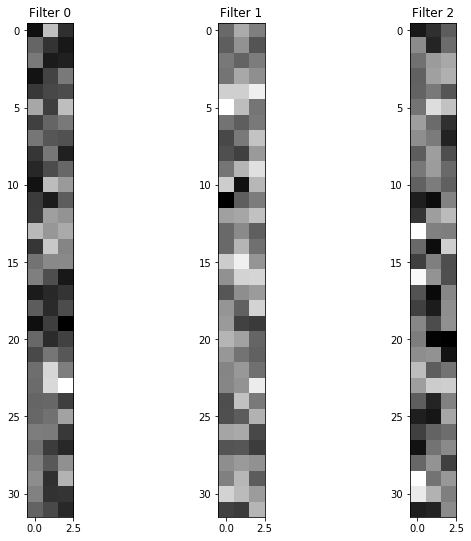

In [30]:
plotNNFilter(net.convI3.weight.cpu().data.numpy())

## 2.8 Evaluating network accuracy
Let's calculate the accuracy on the training set.

In [31]:
def DetermineAccuracy(phase):
    correct = 0
    total = 0
    for data in datasetLoaders[phase]:
        # Inputs
        inputs, labels = data
        if useGPU:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    return correct, total

In [32]:
correct, total = DetermineAccuracy('train')
print('Accuracy of the network for training set is {}%'.format(100 * correct / total))

Accuracy of the network for training set is 99.47486033519553%


Now time to see the accuracy of the test set.

In [33]:
correct, total = DetermineAccuracy('test')
print('Accuracy of the network for test set is {}%'.format(100 * correct / total))

Accuracy of the network for test set is 96.67721518987342%


Let's see individual class performance along with the confusion matrix.

In [34]:
classCorrect = list(0. for i in range(5))
classTotal = list(0. for i in range(5))
confusion = torch.zeros(5, 5)

for i, data in enumerate(testLoader):
    inputs, labels = data
    if useGPU:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)

    classTotal[labels.data.cpu().numpy()[0]] += 1
    confusion[labels.data.cpu().numpy()[0]][predicted[0][0]] += 1
    
    if labels.data.cpu().numpy()[0] == predicted.cpu().numpy()[0][0]:
        classCorrect[labels.data.cpu().numpy()[0]] += 1

for i, cls in enumerate(classCorrect):
    print('Class ' + datasetClasses[i] + ' total: ' + str(classTotal[i]) + ' correct: ' + str(classCorrect[i]) + ' success rate is ' + str(100 * classCorrect[i] / classTotal[i])) 

    
# Normalize confusion matrix
for i in range(5):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Plot confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + datasetClasses, rotation=90)
ax.set_yticklabels([''] + datasetClasses)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

Class defect total: 345.0 correct: 331.0 success rate is 95.94202898550725
Class nonDefect total: 287.0 correct: 280.0 success rate is 97.5609756097561


IndexError: list index out of range

Results are looking good, let's save the model for future use.

In [25]:
torch.save(net, 'SurfaceCNN.net')

I:\Anaconda3\envs\PyTorchEnv\lib\site-packages\torch\serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
